# Introduction to Machine Learning
## Lesson 12 Ensemble Learning
## Introduction

In this lab work, we will explore various ensemble learning techniques. Ensemble learning combines multiple models to improve the overall performance, robustness, and accuracy of predictions.

## Objectives

Learn how to use:
1. Bagging
2. Random Forests
3. AdaBoost

### Bagging

Bagging, or Bootstrap Aggregating, involves training multiple models on different subsets of the training data and averaging their predictions. This technique helps in reducing variance and preventing overfitting. You will learn how to implement bagging and understand its benefits.

### Random Forests

Random Forests are an extension of bagging that uses multiple decision trees. Each tree is trained on a random subset of the data and a random subset of features. This technique improves accuracy and robustness. You will learn how to build and evaluate random forests.

### AdaBoost

AdaBoost, or Adaptive Boosting, combines multiple weak classifiers to create a strong classifier. It adjusts the weights of incorrectly classified instances, focusing more on difficult cases. You will learn how to implement AdaBoost and analyze its effectiveness.

In this lab, you will gain practical experience with these ensemble methods and understand how they can be applied to various machine learning problems.


#### Why ensemble learning? How does it help?
<span style="color:blue"> By combining the power of multiple models in a single
model while overcoming their weaknesses, thus reducing variance and/or bias.

## Ensemble learning
We will explore ensemble learning on the example of decision trees - we will see how ensembles can improve classification accuracy.

Let's start from uploading MNIST dataset.

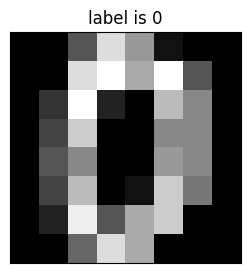

In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

digits = load_digits()
X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)


plt.figure(1, figsize=(3, 3))
plt.imshow(X[0].reshape((8,8)), cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title(f"label is {y[0]}")
plt.show()

### Single decision tree

First, we train a single decision tree.

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
pred = tree.predict(X_test)
tree_score = accuracy_score(y_test, pred)
print("Single tree accuracy:", tree_score)

Single tree accuracy: 0.9122807017543859


Note the accuracy - it is around **0.85**.

### Exercise 1
#### Bagging

What is decreased by bagging? Variance or bias? How?

Now let's improve it a bit by the means of bagging. We train a hundred of independent classifiers and make a prediction by majority voting.

In [3]:
import numpy as np
from scipy.stats import mode

n_trees = 100

classifiers = []
for i in range(n_trees):
    # train a new classifier and append it to the list
    tree = DecisionTreeClassifier()
    tree.fit(X_train, y_train)
    classifiers.append(tree)

# here we will store predictions for all samples and all base classifiers
base_pred = np.zeros((X_test.shape[0], n_trees), dtype="int")
for i in range(n_trees):
    # obtain the predictions from each tree
    base_pred[:,i] = classifiers[i].predict(X_test)

for i in range(5):
    print(f'Predictions for the {i}th sample')
    sample_pred, sample_pred_count = np.unique(base_pred[i], return_counts=True)
    for j in range(len(sample_pred)):
        print(sample_pred_count[j],'Trees predicted', sample_pred[j])
    print()

# aggregate predictions by majority voting
pred = mode(base_pred, axis=1)[0].ravel()
acc = accuracy_score(y_test, pred)
print("Bagging accuracy:", acc)

Predictions for the 0th sample
66 Trees predicted 3
34 Trees predicted 8

Predictions for the 1th sample
100 Trees predicted 8

Predictions for the 2th sample
100 Trees predicted 2

Predictions for the 3th sample
100 Trees predicted 6

Predictions for the 4th sample
100 Trees predicted 6

Bagging accuracy: 0.8787878787878788


Now the accuracy grew up to **0.88**. Also, you can see that our classifiers
return very similar results.

Let's compare our bagging to SKlearn

In [4]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9747474747474747

## Question:
### Why our performance is much lower then sklearn? 
<span style="color:blue">
Because the base classifiers are identical. The only difference might be when
the improvement of the criterion is identical for several splits and one split
has to be selected at random.
</span>

---
### Exercise 2
#### Random forest

Compared to the simple bagging we've just implemented, random forest can show
better results because base classifiers are much less correlated.

At first, let's implement bootstrap sampling.

In [5]:
def bootstrap(X, y):
    # generate bootstrap indices and return data according to them
    ind = np.random.randint(0, X.shape[0], X.shape[0])
    return X[ind,:], y[ind]


# this is a test, will work if you are using np.random.randint() for indices generation
np.random.seed(0)
a = np.array(range(12)).reshape(4,3)
b = np.array(range(4))
bootstrap(a, b)

(array([[ 0,  1,  2],
        [ 9, 10, 11],
        [ 3,  4,  5],
        [ 0,  1,  2]]),
 array([0, 3, 1, 0]))

You should get

(array([[ 0,  1,  2], <br>
&emsp;&emsp;&emsp;[ 9, 10, 11], <br>
&emsp;&emsp;&emsp;[ 3,  4,  5], <br>
&emsp;&emsp;&emsp;[ 0,  1,  2]]), <br>
array([0, 3, 1, 0]))

Now let's build a set of decision trees, each of them is trained on a bootstrap
sampling from X and $\sqrt d$ features.

In [6]:
classifiers = []
for i in range(n_trees):
    # train a new tree on sqrt(n_features) and bootstrapped data, append it to the list
    base = DecisionTreeClassifier(max_features="sqrt", random_state=42)
    bs_X, bs_y = bootstrap(X_train, y_train)
    base.fit(bs_X, bs_y)
    classifiers.append(base)

base_pred = np.zeros((n_trees, X_test.shape[0]), dtype="int")
for i in range(n_trees):
    base_pred[i,:] = classifiers[i].predict(X_test)

pred = mode(base_pred, axis=0)[0].ravel()
acc = accuracy_score(y_test, pred)
print("Random forest accuracy:", acc)

Random forest accuracy: 0.9814814814814815


And now we got **0.98** accuracy, which is a significant improvement! Now you
can see why it is so important to have diverse classifiers.

---
### Exercise 3
#### Boosting

How does boosting work? <span style="color:blue"> Models are built sequentially:
each model is built using information from previously built models. Boosting
does not involve bootstrap sampling; instead each tree is fit on a modified
version of the original data set. </span>

For simplicity let's solve a binary classification problem

In [7]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
data['target'][data['target']==0] = -1  # turn 0s to -1 to make the calculations easier
X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], test_size=0.2, random_state=0)

Now let's train a boosting model.

We will have sample weights and tree weights. Initially all sample weights are equal. After that we will increase weight for complicated samples.

Tree weight $w$ is computed using weighted error or $1 - accuracy$

$w_t = \frac12 log(\frac{1-weighted\_error_t}{weighted\_error_t})$ for each base classifier.

For correct samples weights will be decreased $e^w$ times, and for incorrect classified samples increased  $e^w$ times. After this changes we normalize weights.

In [8]:
n_trees = 3
tree_weights = np.zeros(n_trees)
classifiers = []
train_samples = X_train.shape[0]
# initialize sample weights
sample_weights = np.ones(train_samples) / train_samples
for i in range(n_trees):
    clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
    clf.fit(X_train, y_train, sample_weight=sample_weights)
    pred = clf.predict(X_train)
    acc = accuracy_score(y_train, pred, sample_weight=sample_weights)
    # Calculate tree weight
    w = 0.5 * np.log(acc / (1 - acc))
    tree_weights[i] = w
    classifiers.append(clf)
    # Update sample weights
    for j in range(train_samples):
        if pred[j] != y[j]:
            sample_weights[j] = sample_weights[j] * np.exp(w)
        else:
            sample_weights[j] = sample_weights[j] * np.exp((-w))
    # Normalize the weights
    sample_weights = sample_weights / np.sum(sample_weights)

Use trees voting to calculate final predictions. Since we have a binary classification, the prediction will be calculated as follows:

$\hat{y} = sign(\sum_{t=1}^{T}(w_t f_t(x)))$

In [9]:
n_test = X_test.shape[0]

pred = np.zeros(n_test)
# Aggregate the  predictions
for t in range(n_trees):
    pred += classifiers[t].predict(X_test) * tree_weights[t]
for i in range(n_test):
    pred[i] = 1 if pred[i] > 0 else -1


acc = accuracy_score(y_test, pred)
print("Boosting accuracy:", acc)


Boosting accuracy: 0.9473684210526315


# [AdaBoost](https://en.wikipedia.org/wiki/AdaBoost)
Sklearn has many ensemble [methods](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)

In [11]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    algorithm='SAMME'
)
clf = clf.fit(X_train, y_train)
print('AdaBoost accuracy:', clf.score(X_test, y_test))


AdaBoost accuracy: 0.9736842105263158


## Conclusion
In this lab work, we explored different methods for building ensemble models in machine learning. We started with the Bagging method, which uses bootstrap to create different subsamples of data and aggregate the results, which helps improve the generalizability of the model. 

We then looked at Random Forests, which combines multiple decision trees to improve the accuracy and robustness of the model. 

Finally, we examined AdaBoost, which consistently trains weak models on weighted subsets of data, focusing on those samples that present the greatest difficulty for previous models.